Train images: (50000, 3, 32, 32)
Train labels: (50000,)
Test images: (10000, 3, 32, 32)
Test labels: (10000,)


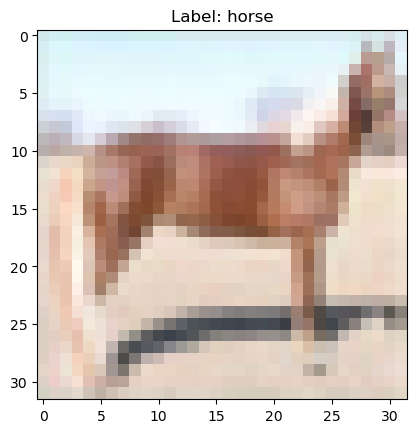

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load CIFAR-10 dataset from OpenML
def load_data():
    cifar10 = fetch_openml("CIFAR_10", version=1, as_frame=False)
    X = cifar10.data.reshape(-1, 3, 32, 32).astype(np.uint8)  # Reshape into images
    y = cifar10.target.astype(int)

    # Split into train and test
    train_x_orig, test_x_orig = X[:50000], X[50000:]
    train_y, test_y = y[:50000], y[50000:]

    classes = np.array(["airplane", "automobile", "bird", "cat", "deer", 
                        "dog", "frog", "horse", "ship", "truck"])  # Class names
    return train_x_orig, train_y, test_x_orig, test_y, classes

# Load data
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

# Print dataset shapes
print(f"Train images: {train_x_orig.shape}")
print(f"Train labels: {train_y.shape}")
print(f"Test images: {test_x_orig.shape}")
print(f"Test labels: {test_y.shape}")

# Show an example image
index = 10
plt.imshow(np.transpose(train_x_orig[index], (1, 2, 0)))  # Convert to (H, W, C)
plt.title(f"Label: {classes[train_y[index]]}")
plt.show()


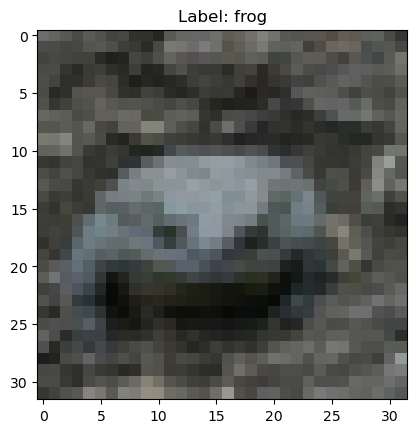

In [4]:
# Example of a picture
index = 25

#plt.imshow(train_x_orig[index])
#print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

plt.imshow(np.transpose(train_x_orig[index], (1, 2, 0)))  # Convert to (H, W, C)
plt.title(f"Label: {classes[train_y[index]]}")
plt.show()

In [6]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[2]

m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 50000
Number of testing examples: 10000
Each image is of size: (32, 32, 3)
train_x_orig shape: (50000, 3, 32, 32)
train_y shape: (50000,)
test_x_orig shape: (10000, 3, 32, 32)
test_y shape: (10000,)


In [8]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (3072, 50000)
test_x's shape: (3072, 10000)


In [ ]:
### CONSTANTS DEFINING THE MODEL ####
n_x = num_px * num_px *3    # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("n_x =",n_x)

In [78]:
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01  # (n_h, n_x) → should match input size
    b1 = np.zeros((n_h, 1))  # (n_h, 1)
    W2 = np.random.randn(n_y, n_h) * 0.01  # (n_y, n_h)
    b2 = np.zeros((n_y, 1))  # (n_y, 1)
    
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}


In [80]:
def compute_cost(AL, Y):
    """
    Computes the binary cross-entropy cost.

    AL -- probability vector corresponding to label predictions, shape (1, m)
    Y -- true labels vector, can be shape (m,) or (1, m)

    Returns:
    cost -- cost value (scalar)
    """
    epsilon = 1e-8
    AL = np.clip(AL, epsilon, 1 - epsilon)
    
    # Ensure Y is a 2D array of shape (1, m)
    if Y.ndim == 1:
        Y = Y.reshape(1, -1)
    
    m = Y.shape[1]
    cost = - (1 / m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    return np.squeeze(cost)


In [82]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implements the forward propagation for a single layer (linear -> activation).

    Arguments:
    A_prev -- activations from previous layer, shape (n_prev, m)
    W -- weights matrix, shape (n, n_prev)
    b -- bias vector, shape (n, 1)
    activation -- "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, shape (n, m)
    cache -- a tuple containing (A_prev, W, b, Z) for backward propagation
    """
    Z = np.dot(W, A_prev) + b
    if activation == "sigmoid":
        A = 1 / (1 + np.exp(-Z))
    elif activation == "relu":
        A = np.maximum(0, Z)
    else:
        raise ValueError("Activation must be 'sigmoid' or 'relu'")
    
    cache = (A_prev, W, b, Z)  # Store all needed values for backpropagation
    return A, cache


In [84]:
def linear_activation_backward(dA, cache, activation):
    """
    Implements the backward propagation for a single layer (linear -> activation).

    Arguments:
    dA -- post-activation gradient for current layer, shape (n, m)
    cache -- tuple of values (A_prev, W, b, Z) from forward propagation
    activation -- "sigmoid" or "relu"

    Returns:
    dW -- gradient of the cost with respect to W, shape (n, n_prev)
    db -- gradient of the cost with respect to b, shape (n, 1)
    dA_prev -- gradient of the cost with respect to A_prev, shape (n_prev, m)
    """
    A_prev, W, b, Z = cache  # Unpack cache (4 values)
    m = A_prev.shape[1]
    
    if activation == "sigmoid":
        s = 1 / (1 + np.exp(-Z))
        dZ = dA * s * (1 - s)
    elif activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    else:
        raise ValueError("Activation must be 'sigmoid' or 'relu'.")
    
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    
    return dW, db, dA_prev


In [86]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    """
    Implements a two-layer neural network.
    """
    np.random.seed(1)
    (n_x, n_h, n_y) = layers_dims

    # Initialize parameters
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

    costs = []
    for i in range(num_iterations):
        # Forward propagation for layer 1
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        # Forward propagation for layer 2
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        # Compute cost (make sure Y is shaped as (1, m))
        cost = compute_cost(A2, Y)
        
        # Backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dW2, db2, dA1 = linear_activation_backward(dA2, cache2, "sigmoid")
        dW1, db1, dA0 = linear_activation_backward(dA1, cache1, "relu")
        
        # Update parameters
        parameters["W1"] -= learning_rate * dW1
        parameters["b1"] -= learning_rate * db1
        parameters["W2"] -= learning_rate * dW2
        parameters["b2"] -= learning_rate * db2
        
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Cost after iteration {i}: {cost}")
                
    return parameters, costs


In [88]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates the parameters W1, b1, W2, b2 using gradient descent.

    Arguments:
    parameters -- Dictionary containing W1, b1, W2, b2
    grads -- Dictionary containing gradients dW1, db1, dW2, db2
    learning_rate -- Learning rate for gradient descent

    Returns:
    parameters -- Updated parameters dictionary
    """

    parameters["W1"] -= learning_rate * grads["dW1"]
    parameters["b1"] -= learning_rate * grads["db1"]
    parameters["W2"] -= learning_rate * grads["dW2"]
    parameters["b2"] -= learning_rate * grads["db2"]

    return parameters


In [90]:
# GRADED FUNCTION: linear_forward

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """    
    Z = np.dot(W, A) + b
    
    cache = (A, W, b)
    
    return Z, cache

In [92]:
# GRADED FUNCTION: linear_backward

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [94]:
def relu(Z):
    """
    Implementa la funzione di attivazione ReLU.
    
    Argomenti:
    Z -- numpy array di qualsiasi forma
    
    Ritorna:
    A -- output della funzione ReLU applicata ad ogni elemento di Z
    cache -- ritorna Z, utile per il backward pass
    """
    A = np.maximum(0, Z)
    cache = Z
    return A, cache
    
def sigmoid(Z):
    """
    Implementa la funzione di attivazione Sigmoide.
    
    Argomenti:
    Z -- numpy array di qualsiasi forma
    
    Ritorna:
    A -- output della funzione Sigmoide applicata ad ogni elemento di Z
    cache -- ritorna Z, utile per il backward pass
    """
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

In [96]:
import matplotlib.pyplot as plt

def plot_costs(costs, learning_rate):
    """
    Plots the cost function value over iterations.
    
    costs -- list or array containing cost values
    learning_rate -- the learning rate used during training
    """
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel(f'Iterations (lr={learning_rate})')
    plt.title('Cost function over iterations')
    plt.show()


In [ ]:
# Number of iterations and learning rate for the model
num_iterations = 1000  # or another desired number of iterations
learning_rate = 0.1  # Adjust based on your needs

# Initialize variables to hold costs over iterations
costs = []

# Loop through the training process
for i in range(num_iterations):
    parameters, current_costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), learning_rate=learning_rate, num_iterations=num_iterations, print_cost=False)
    
    # Append the cost after each iteration
    costs.append(current_costs)
    
    # Optionally, print the cost every 100 iterations (or any interval you'd like)
    if i % 100 == 0:
        print(f"Cost after iteration {i}: {current_costs[0]}")

# Plot the cost graph after all iterations
plot_costs(costs, learning_rate)


C:\Users\Me\AppData\Local\Temp\ipykernel_19072\282304322.py:26: RuntimeWarning: divide by zero encountered in divide
  dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
C:\Users\Me\AppData\Local\Temp\ipykernel_19072\282304322.py:26: RuntimeWarning: invalid value encountered in divide
  dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
C:\Users\Me\AppData\Local\Temp\ipykernel_19072\2824405829.py:20: RuntimeWarning: invalid value encountered in multiply
  dZ = dA * s * (1 - s)


In [ ]:
def predict(X, Y, parameters):
    """
    Predicts the labels of the data X using the trained parameters.

    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    parameters -- parameters of the trained model (W1, b1, W2, b2)

    Returns:
    predictions -- vector of predictions for each example (1 if cat, 0 if non-cat)
    """
    # Forward propagation
    # Retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Implement forward propagation
    A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
    A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")

    # Predictions are based on the output A2
    # Since the output is a probability (between 0 and 1), we threshold it at 0.5 to classify
    predictions = (A2 > 0.5)

    # Calculate the accuracy if you want to print it
    accuracy = np.mean(predictions == Y)

    print(f"Accuracy: {accuracy * 100}%")

    return predictions


In [68]:
predictions_train = predict(train_x, train_y, parameters)
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 10.0%
Accuracy: 10.0%


Accuracy: 0.0%
Prediction: airplane (Your model predicts a airplane picture.)


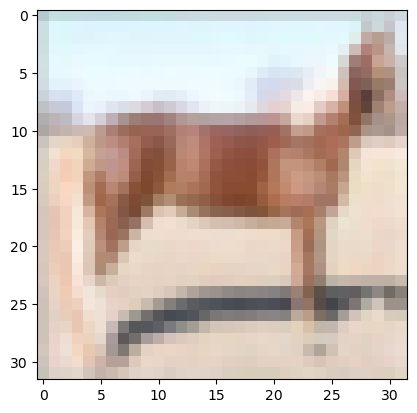

In [66]:
from PIL import Image

my_image = "horse.jpg"  # Replace with your image
my_label_y = [1]  # True label (1 for cat in CIFAR-10)
image = np.array(Image.open(my_image).resize((num_px, num_px)))  # Resize image to match CIFAR-10 size
plt.imshow(image)
image = image / 255.0  # Normalize the image
image = image.reshape((1, num_px * num_px * 3)).T  # Reshape to (n_x, 1) form

# Use model to predict
my_predicted_image = predict(image, my_label_y, parameters)

# Output the predicted class
predicted_class = classes[int(np.squeeze(my_predicted_image))]  # Map prediction to class
print(f"Prediction: {predicted_class} (Your model predicts a {predicted_class} picture.)")